In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from time import time
from functools import partial

jax.config.update("jax_enable_x64", True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport solver.hydro
%aimport solver.solvers
%aimport solver.limiters
%aimport solver.muscl

In [3]:
def imshow(f, size=10, axis=None):
    plt.figure(figsize=(size, size))
    if axis is None:
        extent = None
    else:
        extent = [axis.min(), axis.max(), axis.min(), axis.max()]

    plt.imshow(f, origin="lower", extent=extent)
    plt.colorbar()


def title(e0=1e5, d0=1.0, C=0.5, n=128):
    plt.title("e0={:.0e}   d0={:.0e}   C={:.1f}  n={}".format(e0, d0, C, n))

# Kelvin-Helmholtz

In [52]:
def kelvin_helmholtz_initial_conditions(n, L, a=0.05, sigma=0.2, u_flow=1, P0=10, A=0.01):
    """
    Initialize the conditions for a Kelvin-Helmholtz instability.
    
    Parameters:
    nx, ny: Grid points in x and y directions
    Lx, Ly: Dimensions of the domain in x and y directions
    rho1, rho2: Densities of the two fluids
    v1, v2: Velocities of the two fluids
    delta: Thickness of the transition layer between the two fluids
    
    Returns:
    rho: Density field
    vx: Velocity field in x direction
    vy: Velocity field in y direction (initially zero)
    """
    # Create coordinate arrays
    x = np.linspace(0, L, n) 
    y = np.linspace(0, 2*L, 2*n)
    X, Y = np.meshgrid(x, y, indexing="ij")

    y1 = 0.5 * L
    y2 = 1.5 * L
    

    jump = 0 # delta rho / rho0

    rho = 1 + jump * 0.5 * (np.tanh((Y - y1) / a) - np.tanh((Y - y2) / a))
    ux = u_flow * (np.tanh((Y - y1) / a) - np.tanh((Y - y2) / a) - 1)
    uy = A * np.sin(2 * np.pi * X) * (np.exp(-((Y - y1) / sigma)**2) + np.exp(-((Y - y2) / sigma)**2))
    c = 0.5 * (np.tanh((Y - y2)) - np.tanh((Y - y1)) + 2)

    
    return rho, x, y, ux, uy, c

In [53]:
def create_state(n=1024, L=1.0, gamma=5/3):
    ds = L / n

    P = jnp.ones((n, 2*n)) * 10
    rho, x, y, vx, vy, c = kelvin_helmholtz_initial_conditions(n, L)

    total_energy = P / (gamma - 1) + .5 * rho * (vx**2 + vy**2)
    state = solver.hydro.HydroState(
        n = n,
        ds = ds,
        dx = ds,
        dy = ds,
        x = x,
        y = y,
        density = rho,
        dye_concentration=c,
        total_energy = total_energy,
        momentum_x = vx * rho,
        momentum_y = vy * rho,
        adiabatic_index = gamma,
    )

    return state
    
state = create_state()


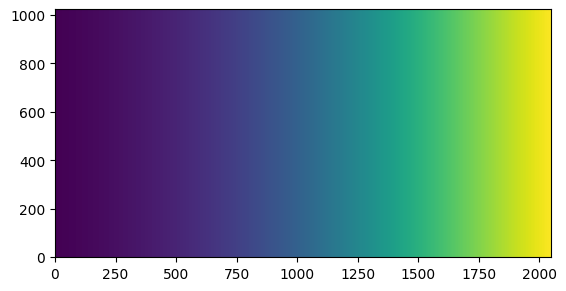

In [57]:
plt.imshow(state.dye_concentration, origin="lower")

In [67]:
def show_state(state, varname="density"):
    extent = [state.y.min(), state.y.max(), state.x.min(), state.x.max()]
    plt.figure(figsize=(10, 10))
    plt.imshow(getattr(state.varname), origin="lower", extent=extent)
    plt.colorbar()

In [68]:
def run_kelvin_helmholtz(n=1024, nt=100, C=0.8):
    jax.config.update("jax_debug_nans", False)

    riemann_solver = solver.solvers.local_lax_friedrichs
    slope_limiter = solver.limiters.monotonized_central
    state = create_state(n=n)
    start = time()

    for it in range(nt):
        dt = solver.hydro.courant_condition(state, C)
        state = solver.muscl.muscl_2d(
            state, dt, slope_limiter=slope_limiter, riemann_solver=riemann_solver
        )
    used = time() - start

    print("total: {:.1f} sec, {:.2f} microseconds/update".format(used, 1e6 * used / (n**2 * nt)))

    return state

state = run_kelvin_helmholtz(n=512, nt=10000, C=0.5)

total: 197.2 sec, 0.08 microseconds/update


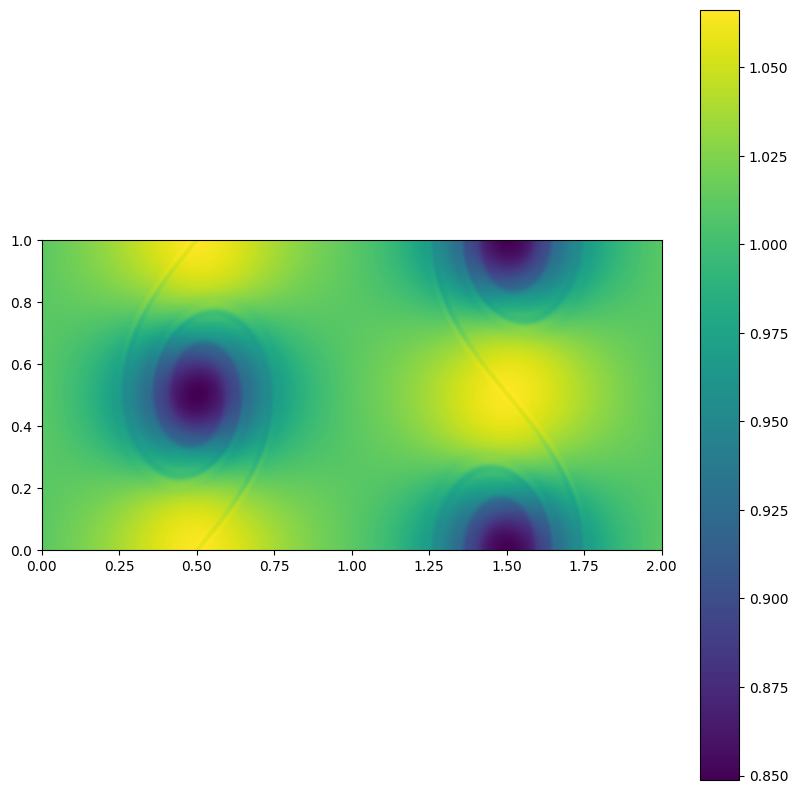

In [69]:
show_state(state)